In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("seaborn-v0_8-darkgrid")

In [2]:
# Set your run prefix and data directory
data_dir = Path(".")              # change if the files live elsewhere
prefix = "lv_poisson_run_20251209"
threshold = 20.0                  # detection threshold used in the run

csv_path = data_dir / f"{prefix}_results.csv"
npz_path = data_dir / f"{prefix}_true_cps.npz"

print("CSV:", csv_path)
print("NPZ:", npz_path)

# Make repo modules importable (if you want compute_metrics)
sys.path.append(str(data_dir.resolve()))
from cpdet.metrics import compute_metrics  # noqa: E402

CSV: lv_poisson_run_20251209_results.csv
NPZ: lv_poisson_run_20251209_true_cps.npz


In [3]:
df = pd.read_csv(csv_path)
gt = np.load(npz_path)

true_cp_idx = gt["cp_idx"]
true_cp_time = gt["cp_time"]
n_obs = int(gt["n_obs"])

print(f"rows={len(df)}, true CP idx={true_cp_idx}, times={true_cp_time}, n_obs={n_obs}")
df.head()

rows=960, true CP idx=[123 244 351 354 409 534 539 927], times=[10.24059206 20.33132944 29.17736044 29.48068321 34.01095252 44.46818515
 44.84173749 77.19587424], n_obs=1000


,T,alt_loglik,alt_theta_0,alt_theta_1,alt_theta_2,alt_theta_3,alt_theta_4,cp_idx_local,first_alt_tau,inferred_change,...,null_theta_1,null_theta_2,null_theta_3,prefix,sec_per_window,slice_start,slice_stop,t,win_end_local,win_start_local
0,0.540852,156.353841,0.596018,0.751931,0.986385,0.598276,0.468302,59,4.166667,0.598142,...,0.752006,0.986240,0.598142,lv_poisson_run_20251209,1.861844,0,110,4.916667,59,0
1,0.652120,155.394537,0.588604,0.749271,0.974336,0.594751,0.464689,60,4.250000,0.594383,...,0.749613,0.973877,0.594383,lv_poisson_run_20251209,1.315672,0,110,5.000000,60,1
2,0.599454,157.231600,0.589527,0.752136,0.943283,0.587369,0.625619,52,4.333333,0.592308,...,0.748239,0.951564,0.592308,lv_poisson_run_20251209,1.202732,0,110,5.083333,61,2
3,1.156538,157.378192,0.582906,0.748204,0.948692,0.589096,0.642529,53,4.416667,0.596428,...,0.742434,0.961971,0.596428,lv_poisson_run_20251209,1.263101,0,110,5.166667,62,3
4,0.750231,157.733376,0.583094,0.746210,0.969248,0.593846,0.636465,54,4.500000,0.599640,...,0.741842,0.980809,0.599640,lv_poisson_run_20251209,1.263729,0,110,5.250000,63,4


In [4]:
mask = df["cp_idx_local"].notna()
if threshold is not None:
    mask &= df["T"] > threshold

det = df.loc[mask].copy()
det["det_idx_global"] = det["slice_start"] + det["win_end_local"]
det["est_idx_global"] = det["slice_start"] + det["cp_idx_local"]
det["det_time"] = det["t"]
det["est_time"] = det["k_time"]
det = det.sort_values("det_time")

print(f"detections above threshold: {len(det)}")
det[["det_time", "T", "det_idx_global", "est_idx_global", "inferred_change"]].head()

detections above threshold: 4


,det_time,T,det_idx_global,est_idx_global,inferred_change
90,12.333333,20.703987,148,139,0.086238
198,21.083333,24.394792,253,244,0.644214
369,34.916667,22.452335,419,410,0.901356
893,77.666667,23.189599,932,926,0.645000


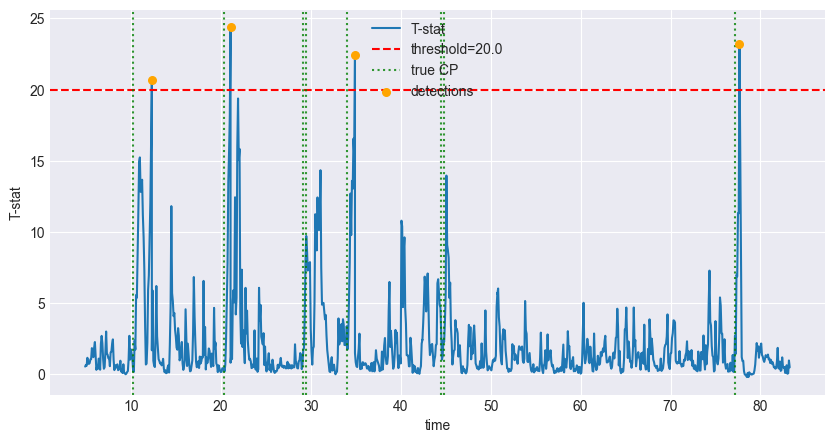

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["t"], df["T"], label="T-stat")

if threshold is not None:
    ax.axhline(threshold, color="red", ls="--", label=f"threshold={threshold}")

for cp in np.atleast_1d(true_cp_time):
    ax.axvline(cp, color="green", ls=":", alpha=0.8, label="true CP" if cp == true_cp_time[0] else None)

if not det.empty:
    ax.scatter(det["det_time"], det["T"], color="orange", s=30, zorder=5, label="detections")

ax.set_xlabel("time")
ax.set_ylabel("T-stat")
ax.legend()
plt.show()

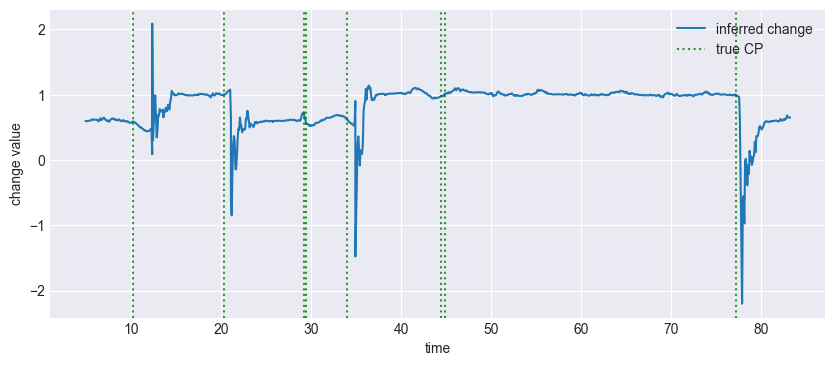

In [6]:
if "inferred_change" in df.columns:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(df["t"], df["inferred_change"], label="inferred change")
    for cp in np.atleast_1d(true_cp_time):
        ax.axvline(cp, color="green", ls=":", alpha=0.8, label="true CP" if cp == true_cp_time[0] else None)
    ax.set_xlabel("time")
    ax.set_ylabel("change value")
    ax.legend()
    plt.show()

In [7]:
metrics = compute_metrics(
    true_cp_idx=true_cp_idx,
    true_cp_time=true_cp_time,
    T=n_obs,
    det_idx=det["det_idx_global"].to_numpy(int),
    det_time=det["det_time"].to_numpy(float),
    est_idx=det["est_idx_global"].to_numpy(int),
    est_time=det["est_time"].to_numpy(float),
    tol_idx=5,
)
metrics

{'FAR': 0.003015075376884422,
 'MAR': 0.875,
 'EDD': 0.4707924263210259,
 'MAE': 0.029207573678974086,
 'Cover': 0.6935684726674153,
 'FP': 3,
 'TP': 1,
 'FN': 7,
 'n_true': 8,
 'n_det': 4}